In [1]:
import pandas as pd
import numpy as np
import h5py
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
print("successfully imported required libraries")

C:\Users\kaush\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


successfully imported required libraries


In [2]:
import tensorflow as tf
from tensorflow.keras import backend as K

# recall 
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#f1 score
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - numerator / denominator
  
def custom_loss_function(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)

In [3]:
from tensorflow import keras
model = keras.models.load_model("model_save.h5", custom_objects={'f1_m':f1_m, 'precision_m':precision_m, 'recall_m':recall_m , 'dice_loss':dice_loss,'custom_loss_function':custom_loss_function })

In [4]:
import os
print(os.getcwd())
os.chdir("Valid")
print(os.getcwd())

C:\Users\kaush\Desktop\Major_Project
C:\Users\kaush\Desktop\Major_Project\Valid


In [5]:
def kaushik(n): #1-245
    validation_url = r"img/image_"+n+".h5"
    img_val = sorted(glob.glob(validation_url))
    print(img_val)
    VAL_XX = np.zeros((1, 128, 128, 13))
    mask_name = []
    for i, img in enumerate(img_val):
        print(i, img)
        mask_name.append(img.split('/')[-1].replace('image', 'mask'))
        with h5py.File(img) as hdf:
            ls = list(hdf.keys())
            data = np.array(hdf.get('img'))

          # assign 0 for the nan value
            data[np.isnan(data)] = 0.000001

          # to normalize the data 
            mid_rgb = data[:, :, 1:4].max() / 2.0
            mid_slope = data[:, :, 12].max() / 2.0
            mid_elevation = data[:, :, 13].max() / 2.0
            mid_aerosol = data[:,:,0].max() / 2.0
            mid_watervapour = data[:,:,9].max() / 2.0
            mid_nir = data[:,:,7].max() / 2.0
            
            data_red = data[:, :, 3]
            data_nir = data[:, :, 7]
            data_b8a = data[:, :, 8]
            data_11  = data[:,:,11]
            data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))
            data_moisture = np.divide(data_b8a - data_11,np.add(data_b8a, data_11)) #moisture calculation
            data_geology = data[:,:,[12,11,2]]  #geology calculation
            mid_geology = data_geology.max() / 2.0
            
          
          # final array
            VAL_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb #RED
            VAL_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb #GREEN
            VAL_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb #BLUE
            VAL_XX[i, :, :, 3] = data_ndvi #NDVI
            VAL_XX[i, :, :, 4] = 1- data[:, :, 13] / mid_slope #SLOPE
            VAL_XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation #ELEVATION
            
            VAL_XX[i, :, :, 6] = 1 - data[:, :, 0] / mid_aerosol #Aerosol
            VAL_XX[i, :, :, 7] = data_moisture #Moisture
            VAL_XX[i, :, :, 8] = 1 - data[:, :, 9] / mid_watervapour #Water Vapour
            VAL_XX[i, :, :, 9] = 1 - data[:, :, 7] / mid_nir #Near Infrared
            VAL_XX[i, :, :, 10] = 1 - data[:,:,12] / mid_geology #Geology
            VAL_XX[i, :, :, 11] = 1 - data[:,:,11] / mid_geology #Geology
            VAL_XX[i, :, :, 12] = 1 - data[:,:,2] / mid_geology #Geology
    print(VAL_XX.shape)
    return VAL_XX  
  

Enter the number of the file: 171
['img/image_171.h5']
0 img/image_171.h5
(1, 128, 128, 13)
(1, 128, 128, 13)
(1, 128, 128, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


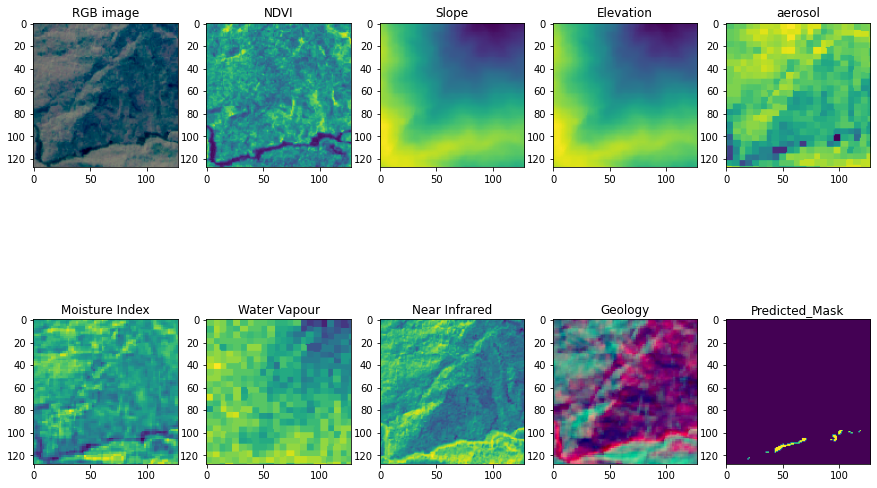

In [7]:
n = input("Enter the number of the file: ")
threshold = 0.5
VAL_XX = kaushik(n)
print(VAL_XX.shape)
pred_img = model.predict(VAL_XX)
pred_img = (pred_img > threshold).astype(np.uint8)
print(pred_img.shape)

"""data_red = VAL_XX[0,:, :, 3]
data_nir = VAL_XX[0,:, :, 7]
data_b8a = VAL_XX[0,:, :, 8]
data_11 = VAL_XX[0,:, :, 11]
data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red)) #ndvi calculation
data_moisture = np.divide(data_b8a - data_11,np.add(data_b8a, data_11)) #moisture calculation
data_geology = VAL_XX[0,:,:,[12,11,2]]  #geology calculation
"""

fig,( (ax1,ax2, ax3, ax4, ax5),(ax6,ax7,ax8,ax9,ax10) )= plt.subplots(2,5,figsize=(15,10))
ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("aerosol")
ax6.set_title("Moisture Index")
ax7.set_title("Water Vapour")
ax8.set_title("Near Infrared")
ax9.set_title("Geology")    
ax10.set_title("Predicted_Mask")

ax1.imshow(VAL_XX[0, :, :, 0:3])
ax2.imshow(VAL_XX[0, :, :, 3])
ax3.imshow(VAL_XX[0, :, :, 4])
ax4.imshow(VAL_XX[0, :, :, 5])
ax5.imshow(VAL_XX[0, :, :, 6])
ax6.imshow(VAL_XX[0, :, :, 7])
ax7.imshow(VAL_XX[0, :, :, 8])
ax8.imshow(VAL_XX[0, :, :, 9])
ax9.imshow(VAL_XX[0, :, :, 10:13])
ax10.imshow(pred_img[0, :, :, 0])

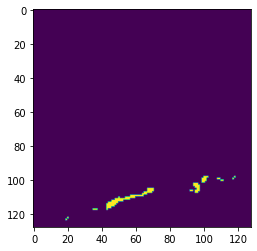

In [9]:
plt.imshow(pred_img[0, :, :, 0])

In [10]:
a = pred_img[0,:,:,0]
b = np.count_nonzero(a==1)
print(b)
a1 = (128*128*10*10)/(1000*1000)
b1 = (b*10*10)/(1000*1000)
print("Total area: ",a1,"km^2")
print("Landslide area: ", b1,"km^2")

109
Total area:  1.6384 km^2
Landslide area:  0.0109 km^2


In [12]:
array = pred_img[0,:,:,0]
threshold = (array.min() + array.max()) / 2

total_value_count = np.prod(array.shape)
high_value_count  = np.sum(array > threshold) 
low_value_count   = total_value_count - high_value_count

high_low_ratio = (high_value_count / low_value_count)
high_all_ratio = (high_value_count / total_value_count)
low_all_ratio  = (low_value_count  / total_value_count)

print(f"Ratio of yellow region over purple region {high_low_ratio*100:.3f}%")
print(f"Ratio of yellow region over total {high_all_ratio*100:.3f}%")
print(f"Ratio of purple region over total {low_all_ratio*100:.3f}%")

Ratio of yellow region over purple region 0.670%
Ratio of yellow region over total 0.665%
Ratio of purple region over total 99.335%
